IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

<font size="+1" color="RED"><b>[Q]</b></font> <font size="+1"><b>Indiquer dans la boîte ci-dessous vos noms et prénoms :</b></font>

Samy (Adem) YAZID & Alex XU

Ce projet peut être fait en binôme (d'un même groupe). Le nom de chaque membre du binôme doit être indiqué, et un seul rendu sur un des deux comptes Moodle doit être fait.

Les groupes de plus de 2 personnes ne sont pas autorisés.

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>projet-1</tt> et rajouter à la suite de <tt>projet-1</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au notebook** : *projet-1-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme

**Le compte-rendu doit être rendu sur la page Moodle.**

# Projet 1 - février-mars 2023


<font size="+1" color="RED"><b>Date de rendu : jeudi 22 mars, 18h au plus tard</b></font>
<br />


Vous devez compléter ce notebook en rajoutant vos expérimentations avec vos algorithmes d'apprentissage sur les 2 datasets fournis dans le répertoire data-projet:
- les données data-2D.pkl : données en 2 dimensions, 2 labels
- les données data-5D.pkl : données en 5 dimensions, 2 labels

## Travail à faire

Pour chaque ensemble de données:
- les 3 algorithmes d'apprentissage knn, perceptron et perceptron biais doivent être expérimentés et comparés (ATTENTION: on ne veut que des algorithmes que vous avez implémentés vous-même dans cette UE).
- des résultats d'expérimentations doivent fournir une comparaison des taux de bonne classification apprentissage / test avec validation croisée en 10.
- des courbes (coût, poids, variation d'accuracy,...) doivent être fournies pour étudier les modèles construits.

Vos **expérimentations doivent être expliquées**... (utilisez des boîtes Markdown pour saisir vos explications):
- une argumentation du type *"pourquoi vous avez fait cette expérimentation"* doit être fournie;
- une analyse succincte du résultat fourni doit être aussi donnée.



Par exemple (indicatif): choix de $k$ pour le knn:
- argumentation : pour décider quelle peut être la valeur de $k$ optimale, on décide de tester plusieurs valeurs différentes et de comparer les taux de bonne classification sur la base de test obtenus.
- analyse du résultat: on remarque que la valeur $k$ suivante fournie le meilleur résultat.
- étude du temps d'exécution.


## Travail à rendre
Ce qui doit être rendu : un fichier archive (`.tar`, `.tgz`, ou `.zip` uniquement) contenant uniquement ce notebook, dans lequel vous avez reporté toutes les fonctions que vous utilisez : ce notebook doit pouvoir être exécuté sans autre apport (pensez à vous en assurer avant de le rendre). Les fichiers de données ne doivent pas être inclus dans votre archive !



## Lecture des pickles

In [1]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import seaborn as sns

# Importation de la librairie pickle
import pickle as pkl

path2D = "data-projet/data-2D.pkl"
path5D = "data-projet/data-5D.pkl"

# lecture des donnéees en dimension 2 dans un dataframe pandas
data2D = pkl.load(open(path2D, 'rb')) 
X2D = np.array(data2D[['x1', 'x2']], dtype=float) # conversion de type pour une meilleure compatibilité
Y2D = np.array(data2D['label'], dtype=float)

# lecture des donnéees en dimension 5 dans un dataframe pandas
data5D = pkl.load(open(path5D, 'rb')) 
X5D = np.array(data5D[['x1', 'x2', 'x3', 'x4', 'x5']], dtype=float) # conversion de type pour une meilleure compatibilité
Y5D = np.array(data5D['label'], dtype=float)

## Importation des Classifieurs

In [2]:
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")

    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        ratio = 0
        for i in range(len(desc_set)):
            if self.predict(desc_set[i]) == label_set[i]:
                ratio += 1
        return ratio/len(desc_set)


class ClassifierKNN(Classifier):
    """ Classe pour représenter un classifieur par K plus proches voisins.
        Cette classe hérite de la classe Classifier
    """
    def __init__(self, input_dimension, k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - k (int) : nombre de voisins à considérer
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        self.k = k
        
    def score(self, x):
        """ rend la proportion de +1 parmi les k ppv de x (valeur réelle)
            x: une description : un ndarray
        """
        score = 0
        liste_dist_pts = []
        for point in self.data_set:
            v = [point[j]-x[j] for j in range(len(x))]
            liste_dist_pts.append(np.linalg.norm(v))
        liste_dist_pts = np.array(liste_dist_pts).argsort()
        for index in liste_dist_pts[:self.k]:
            if self.label_set[index] == 1:
                score += 1
        return (score/self.k)*2 - 1
            
    
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
            x: une description : un ndarray
        """
        if self.score(x) >= 0:
            return 1
        else:
            return -1

    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        self.data_set = desc_set
        self.label_set = label_set


class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        self.learning_rate = learning_rate
        if init:
            self.w = np.zeros(input_dimension)
        else:
            self.w = np.array([0.001*(2*np.random.uniform()-1) for i in range(input_dimension)])
        self.allw = [self.w.copy()] # stockage des premiers poids
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """        
        indice = [i for i in range(len(desc_set))]
        np.random.shuffle(indice)
        for i in indice:
            #xi = desc_set[i] , yi = label_set[i]
            if self.predict(desc_set[i]) != label_set[i]:
                self.w += self.learning_rate * label_set[i].copy() * desc_set[i].copy()
                self.allw.append(self.w.copy())
            
     
    def train(self, desc_set, label_set, nb_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - nb_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """
        diff = 1
        iteration = 0
        liste_diff = []
        while iteration < nb_max and diff > seuil:
            w_avant = self.w.copy()
            self.train_step(desc_set, label_set)
            w_diff = np.zeros(len(self.w))
            for i in range(len(self.w)):
                w_diff[i] = abs(w_avant[i] - self.w[i])
            diff = np.linalg.norm(w_diff)
            liste_diff.append(diff)
            iteration += 1
        return liste_diff
        
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.dot(x, self.w)
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        if self.score(x) >= 0:
            return 1
        else:
            return -1
        
    def get_allw(self):
        return self.allw
    
class ClassifierPerceptronBiais(ClassifierPerceptron):
    """ Perceptron de Rosenblatt avec biais
        Variante du perceptron de base
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        # Appel du constructeur de la classe mère
        super().__init__(input_dimension, learning_rate, init)
        # Affichage pour information (décommentez pour la mise au point)
        # print("Init perceptron biais: w= ",self.w," learning rate= ",learning_rate)
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """        
        indice = [i for i in range(len(desc_set))]
        np.random.shuffle(indice)
        for i in indice:
            #xi = desc_set[i] , yi = label_set[i]
            if self.score(desc_set[i])*label_set[i] < 1:
                self.w += self.learning_rate * (label_set[i] - self.score(desc_set[i])) * desc_set[i]
            self.allw.append(self.w.copy())

## Importation de fonctions utiles

In [3]:
def genere_train_test(desc_set, label_set, n_pos, n_neg):
    """ permet de générer une base d'apprentissage et une base de test
        desc_set: ndarray avec des descriptions
        label_set: ndarray avec les labels correspondants
        n_pos: nombre d'exemples de label +1 à mettre dans la base d'apprentissage
        n_neg: nombre d'exemples de label -1 à mettre dans la base d'apprentissage
        Hypothèses: 
           - desc_set et label_set ont le même nombre de lignes)
           - n_pos et n_neg, ainsi que leur somme, sont inférieurs à n (le nombre d'exemples dans desc_set)
    """
    #base d'apprentissage:
    L_train = rd.sample([elem[0] for elem in np.argwhere(label_set == 1)], n_pos) +\
              rd.sample([elem[0] for elem in np.argwhere(label_set == -1)], n_neg)
    desc_set_train = desc_set[L_train]
    label_set_train = label_set[L_train]

    #base de test:
    L_test = [i for i in range(0, len(desc_set)) if i not in L_train]
    desc_set_test = desc_set[L_test]
    label_set_test = label_set[L_test]
    
    return (desc_set_train, label_set_train), (desc_set_test, label_set_test)

# ------------------------------------------------

def temps_exec(func, args):
    """
    Paramètres:
    func : function
        Fonction dont on souhaite connaître le temps d'exécution 
    args : list(all_type)
        Arguments pris par la fonction func
        
    Retourne:
    temps : float
        Temps d'exécution de la fonction

    Description:
    Retourne le temps d'exécution de la fonction func munis de ses arguments *args
    """
    #on commence le timer (donc on stocke dans une variable le temps processeur juste avant d'appeler func)
    start_time = time.time()
    #on exécute func munis de ses arguments stockés dans args
    func(*args)
    #on termine le timer (donc on stocke dans une autre variable le temps processeur juste après l'appel de func)
    end_time = time.time()
    #on calcule le temps d'exécution de func que l'on stocke dans la variable temps
    temps = (end_time - start_time)
    #on retourne temps
    return temps

# ------------------------------------------------

def crossval(X, Y, n_iterations, iteration):
    Xtest = X[iteration*(len(X)//n_iterations):(iteration+1)*(len(X)//n_iterations)]
    Ytest = Y[iteration*(len(Y)//n_iterations):(iteration+1)*(len(Y)//n_iterations)]
    Xapp = np.concatenate((X[0:iteration*(len(X)//n_iterations)], X[(iteration+1)*(len(X)//n_iterations):len(X)]))
    Yapp = np.concatenate((Y[0:iteration*(len(Y)//n_iterations)], Y[(iteration+1)*(len(Y)//n_iterations):len(Y)]))   
    return Xapp, Yapp, Xtest, Ytest

# ------------------------------------------------

def analyse_perfs(L):
    """ L : liste de nombres réels non vide
        rend le tuple (moyenne, écart-type)
    """
    moyenne = sum(L)/len(L)
    ecart_type = np.sqrt(sum([(x-moyenne)**2 for x in L])/len(L))
    return (moyenne, ecart_type)

# ------------------------------------------------

def key_of_max(dico):
    keymax = -1
    valmax = -1
    for key in dico:
        if dico[key] > valmax:
            keymax = key
            valmax= dico[key]
    return keymax

# ------------------------------------------------

def plot2DSet(desc,labels):    
    """ ndarray * ndarray -> affichage
        la fonction doit utiliser la couleur 'red' pour la classe -1 et 'blue' pour la +1
    """
    # Extraction des exemples de classe -1:
    data_negatifs = desc[labels == -1]
    # Extraction des exemples de classe +1:
    data_positifs = desc[labels == +1]
    # 'x' rose clair pour la classe -1:
    plt.scatter(data_negatifs[:,0],data_negatifs[:,1],marker='x', color="lightpink")
    # '+' cyan foncé pour la classe +1:
    plt.scatter(data_positifs[:,0],data_positifs[:,1],marker='+', color="darkcyan")

# ------------------------------------------------

def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
        et plus le tracé de la frontière sera précis.        
        Cette fonction affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
    plt.contourf(x1grid,x2grid,res,colors=["lightgrey","darkgrey"],levels=[-1000,0,1000])

## Description du dataset 2D :<br>
Notre dataset 2D est constituée de 3 variables décrivant un point $x$ associé à un label ($-1$ ou $1$):<br>
**x1** : La coordonnée en abscisses de notre point $x$<br>
**x2** : La coordonnée en ordonnées de notre point $x$<br>
**label** : Le label associé au point $x$<br><br>
Affichons le dataset :

In [4]:
data2D.head()

,x1,x2,label
0,0.830557,-2.250314,-1
1,0.627488,-2.533405,-1
2,-1.279837,-1.630564,-1
3,2.002088,-3.415239,-1
4,3.141847,-0.376081,-1


Faisons une brève analyse du dataset :

In [5]:
data2D.describe()

,x1,x2,label
count,2000.000000,2000.000000,2000.00000
mean,0.765090,-0.730506,0.00000
std,2.150353,2.705023,1.00025
min,-4.423879,-7.614040,-1.00000
25%,-0.873869,-2.772921,-1.00000
50%,0.950062,-1.296313,0.00000
75%,2.279826,1.442573,1.00000
max,7.617202,6.193108,1.00000


Tout d'abord, nous pouvons constater que notre dataset contient $2000$ entrées.<br>
Les coordonnées (**x1** & **x2**) vont de $-7.614040$ à $7.617202$.<br>
Déterminons le nombre de point ayant pour **label** $-1$ et le nombre de point ayant pour **label** $1$ :

In [6]:
data2D[['label']].value_counts()

label
-1       1000
 1       1000
dtype: int64

On remarque donc qu'il y a $1000$ points qui ont pour **label** $-1$ et $1000$ points qui ont pour **label** $1$.<br><br>
Montrons à présent la densité de probabilité de chaque variable selon son label :

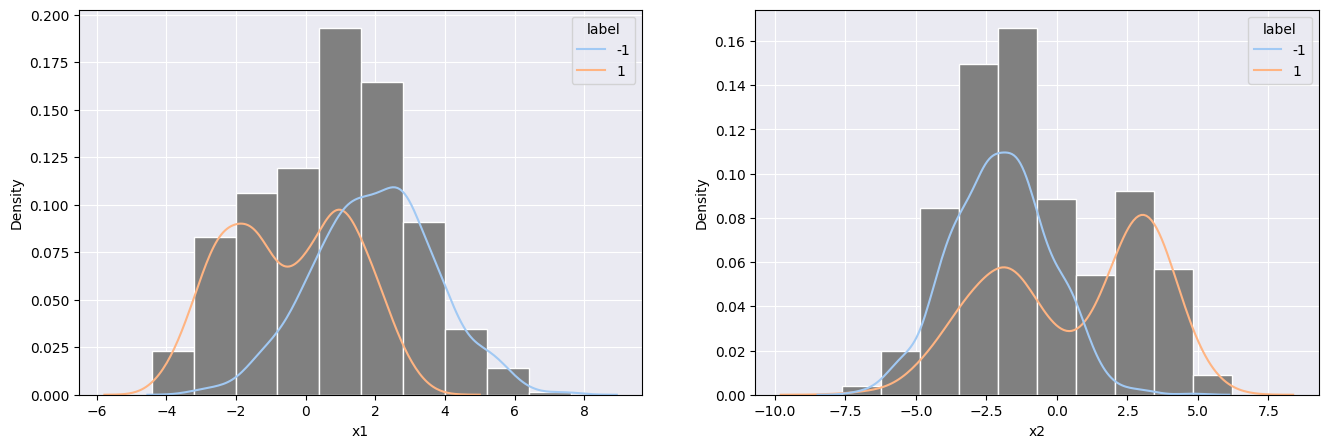

In [7]:
#Avoir un fond gris pour tous les plots
plt.rc('axes', axisbelow=True)
plt.rcParams['axes.facecolor'] = '#EAEAF2'

# Créer un graph pour chaque variable
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Itérer sur toutes les variables sauf Class
for i, var in enumerate(data2D.columns[:-1]):
    # Sélectionner le graph en utilisant l'index de la boucle
    plt.subplot(1,2,i+1)
    plt.grid(color = 'white')
    #Histogramme de la densité de chaque variable
    plt.hist(data2D[var], density=True, color = 'gray', ec="white")
    #Courbe de densité de chaque variable par rapport à la classe
    sns.kdeplot(data=data2D, x=var, hue="label", palette=sns.color_palette("pastel")[:2])
plt.show()

Affichons à présent la répartition des points en fonction des variables pour avoir un aperçu de leurs corrélations.

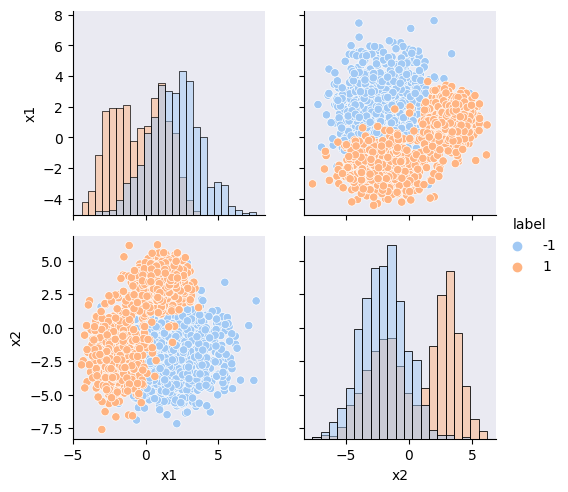

In [8]:
ggpair = sns.PairGrid(data2D, hue="label", palette=sns.color_palette("pastel")[:2])

ggpair.map_diag(sns.histplot)
ggpair.map_offdiag(sns.scatterplot)
ggpair.add_legend()
plt.show()

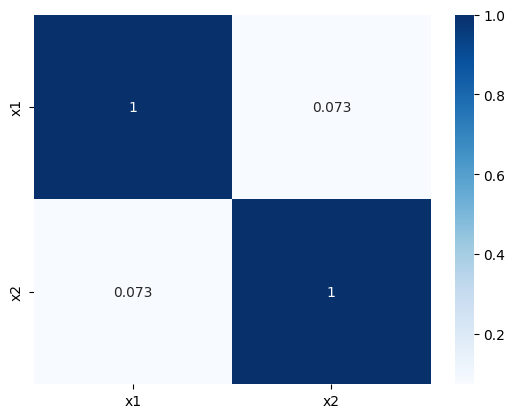

In [9]:
corr = data2D.drop(['label'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()

On observe bien que la corrélation entre **x1** et **x2** est très faible, ce qui nous assure que l'on va bien pouvoir classifier les points à l'aide de leurs coordonnées.

## Classification du dataset 2D :<br>

Commençons par séparer nos données en un ensemble d'entraînement et un ensemble de test.<br>
En utilisant un ensemble de données pour entraîner un modèle et un autre ensemble pour le tester, on peut évaluer la capacité du modèle à généraliser ses prédictions à des données qu'il n'a pas vues lors de l'entraînement.<br>
De plus, la séparation des données en ensembles d'entraînement et de test sera effectuée de manière aléatoire pour éviter de biaiser les résultats.<br><br>
On choisit de d'affecter $1500$ entrées dans la base d'entraînement et $500$ entrées dans la base de test.

In [37]:
(train_desc, train_label), (test_desc, test_label) = genere_train_test(X2D, Y2D, 750, 750)

print("Base d'apprentissage: ",train_desc.shape, " et ", len(train_label)," labels")
print("Base de test: ",test_desc.shape, " et ", len(test_label)," labels")

Base d'apprentissage:  (1500, 2)  et  1500  labels
Base de test:  (500, 2)  et  500  labels


### Classifieur KNN (K- Nearest Neighbours) :<br>

Le premier classifieur que nous allons utiliser est le classifieur KNN (k-plus proches voisins) qui n'a qu'un paramètre arbitraire : **k**.<br>
Nous allons donc essayer de déterminer le **k** optimal pour maximiser le taux de bonne classification sur notre dataset.

In [11]:
dict_accuracy_KNN_2D = {}

for k in range(1, 22, 2):
    perfKNN_2D = []
    #Crossvalidation de 10 :
    index = np.random.permutation(len(train_desc)) # mélange des index
    Xm = train_desc[index]
    Ym = train_label[index]
    for i in range(10):
        Xapp, Yapp, Xtest, Ytest = crossval(Xm, Ym, 10, i)
        KNN_2D = ClassifierKNN(2, k) #(dimension, k)
        KNN_2D.train(Xapp, Yapp)
        perfKNN_2D.append(KNN_2D.accuracy(Xtest, Ytest))
        
    #on stocke les résultats dans la liste associée
    dict_accuracy_KNN_2D[k] = analyse_perfs(perfKNN_2D)[0]

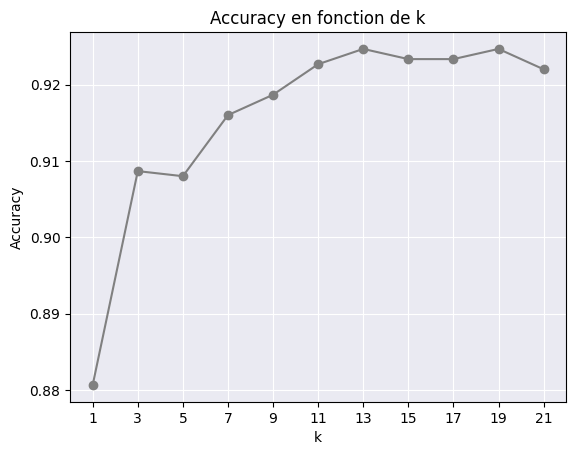

Le k ayant la meilleure accuracy est : 13
Accuracy :  0.9246666666666667
On voit que le k optimal est  13 on choisit donc k =  13 pour notre classifieur final


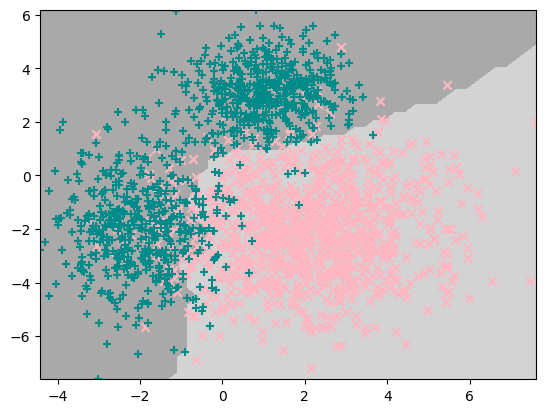

In [12]:
#tracé de la variation de l'accuracy en fonction de k
plt.plot(list(dict_accuracy_KNN_2D.keys()), list(dict_accuracy_KNN_2D.values()), color = "gray")
plt.scatter(list(dict_accuracy_KNN_2D.keys()), list(dict_accuracy_KNN_2D.values()), color = "gray")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction de k")
plt.grid(color = "white")
plt.xticks(np.arange(1, 22, 2))
plt.show()

best_k_2d = key_of_max(dict_accuracy_KNN_2D)
print("Le k ayant la meilleure accuracy est :", best_k_2d)
print("Accuracy : ", dict_accuracy_KNN_2D[best_k_2d])
print("On voit que le k optimal est ", best_k_2d, "on choisit donc k = ", best_k_2d, "pour notre classifieur final")

# tracé de la frontière de décision
plot_frontiere(X2D, Y2D, KNN_2D, step=50)
plot2DSet(X2D, Y2D)

La frontière de décision est très précise et s'adapte particulièrement bien au dataset proposé.<br>
Cela nous présage de très bons résultats à venir sur l'accuracy finale du Classifieur KNN.

Maintenant que nous avons déterminé le meilleur hyperparamètre, on recrée un Classifieur avec le bon hyperparamètre, et on regarde quel est son taux de bonne classification.

In [13]:
KNN_2D = ClassifierKNN(2, best_k_2d) #(dimension, k)
KNN_2D.train(train_desc, train_label)

print("Taux de bonne classification sur le dataset d'entraînement: ", KNN_2D.accuracy(train_desc, train_label))
print("Taux de bonne classification sur le dataset de test: ", KNN_2D.accuracy(test_desc, test_label))
print("Taux de bonne classification sur le dataset total", KNN_2D.accuracy(X2D, Y2D))

Taux de bonne classification sur le dataset d'entraînement:  0.928
Taux de bonne classification sur le dataset de test:  0.924
Taux de bonne classification sur le dataset total 0.927


### Classifieur Perceptron :<br>

Nous allons maintenant utiliser le classifieur Perceptron, qui a 2 paramètres arbitraires:<br>
- **learning_rate** (par défaut 0.01), aussi appelé **epsilon**<br>
- **init** est le mode d'initialisation de w: <br>
    - si True (par défaut): initialisation à 0 de w<br>
    - si False : initialisation par tirage aléatoire de valeurs petites<br>
    
Nous allons donc essayer de déterminer le couple (**epsilon**, **init**) optimal pour maximiser le taux de bonne classification sur notre dataset.

In [14]:
#np.random.seed(42)
dict_accuracy_P2D = {}
list_epsilon = [0.000001,   0.00001,  0.0001,   0.001,   0.01,   0.1,   1]

for init, k1 in zip([True, False], [0, len(list_epsilon)]):
    perfPerceptron_2D = []
    #Crossvalidation de 10 :
    index = np.random.permutation(len(train_desc)) # mélange des index
    Xm = train_desc[index]
    Ym = train_label[index]
    for epsilon, k2 in zip(list_epsilon, range(len(list_epsilon))):
        for i in range(10):
            Xapp, Yapp, Xtest, Ytest = crossval(Xm, Ym, 10, i)
            Perceptron_2D = ClassifierPerceptron(2, epsilon, init) #(dimension, epsilon, init)
            Perceptron_2D.train(Xapp, Yapp)
            perfPerceptron_2D.append(Perceptron_2D.accuracy(Xtest, Ytest))
        
        #on stocke les résultats dans la liste associée
        dict_accuracy_P2D[k1+k2] = analyse_perfs(perfPerceptron_2D)[0]

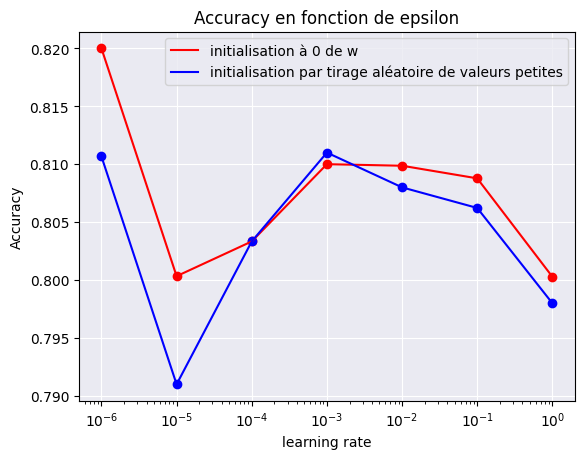

Initialisation à 0 de w
Le learning rate ayant la meilleure accuracy est : 1e-06
Accuracy :  0.82
Init perceptron: w=  [0. 0.]


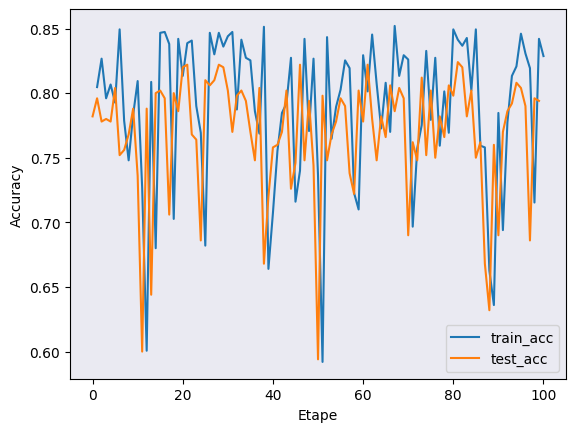

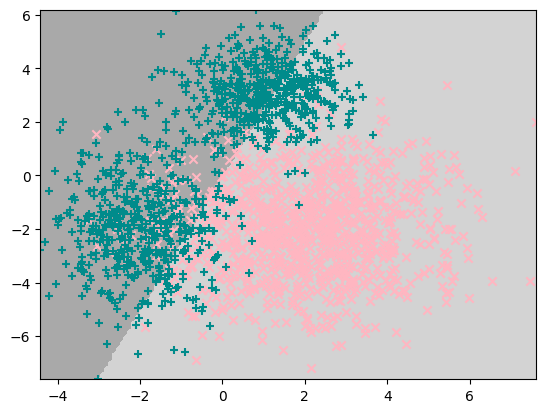

In [15]:
best_epsilon_key = key_of_max(dict_accuracy_P2D)
mode = best_epsilon_key <= len(list_epsilon)//2
best_epsilon = list_epsilon[key_of_max(dict_accuracy_P2D)%len(list_epsilon)]

#tracé de la variation de l'accuracy en fonction de epsilon
plt.plot(list_epsilon, list(dict_accuracy_P2D.values())[:len(list_epsilon)], color = "red")
plt.plot(list_epsilon, list(dict_accuracy_P2D.values())[len(list_epsilon):], color = "blue")
plt.scatter(list_epsilon, list(dict_accuracy_P2D.values())[:len(list_epsilon)], color = "red")
plt.scatter(list_epsilon, list(dict_accuracy_P2D.values())[len(list_epsilon):], color = "blue")
plt.legend(["initialisation à 0 de w", "initialisation par tirage aléatoire de valeurs petites"])
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction de epsilon")
plt.grid(color = "white")
plt.xscale("log")
plt.show()

if(mode):
    print("Initialisation à 0 de w")
else:
    print("Initialisation par tirage aléatoire de valeurs petites")
print("Le learning rate ayant la meilleure accuracy est :", best_epsilon)
print("Accuracy : ", dict_accuracy_P2D[best_epsilon_key])

#rd.seed(42)
Perceptron_2D = ClassifierPerceptron(2, best_epsilon, mode) #(dimension, epsilon, init) 

# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []

# Réalisation de N itérations
print("Init perceptron: w= ", Perceptron_2D.w)
N = 100
for i in range(N):
    Perceptron_2D.train_step(train_desc, train_label)
    train_acc.append(Perceptron_2D.accuracy(train_desc, train_label))
    test_acc.append(Perceptron_2D.accuracy(test_desc, test_label))

# -----
# Apprentissage du perceptron jusqu'à convergence
#les_variations = Perceptron_2D.train(train_desc, train_label)
#print("Nb iterations réalisées: ", len(les_variations))

# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend(['train_acc','test_acc'])
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
plot_frontiere(X2D, Y2D, Perceptron_2D, step=130)
plot2DSet(X2D, Y2D)

Maintenant que nous avons déterminé le meilleur hyperparamètre, on recrée un Classifieur avec le bon hyperparamètre, et on regarde quel est son taux de bonne classification.

In [16]:
Perceptron_2D = ClassifierPerceptron(2, best_epsilon, mode) #(dimension, learning_rate, init)
Perceptron_2D.train(train_desc, train_label)

print("Taux de bonne classification sur le dataset d'entraînement: ", Perceptron_2D.accuracy(train_desc, train_label))
print("Taux de bonne classification sur le dataset de test: ", Perceptron_2D.accuracy(test_desc, test_label))
print("Taux de bonne classification sur le dataset total", Perceptron_2D.accuracy(X2D, Y2D))

Taux de bonne classification sur le dataset d'entraînement:  0.7866666666666666
Taux de bonne classification sur le dataset de test:  0.77
Taux de bonne classification sur le dataset total 0.7825


### Classifieur Perceptron Biais :<br>

Nous allons terminer par le dernier classifieur, le classifieur Perceptron Biais, qui possède les 2 mêmes paramètres arbitraires que le classifieur Perceptron vu précédemment:<br>
- **learning_rate** (par défaut 0.01), aussi appelé **epsilon**<br>
- **init** est le mode d'initialisation de w: <br>
    - si True (par défaut): initialisation à 0 de w<br>
    - si False : initialisation par tirage aléatoire de valeurs petites<br>
    
Nous allons donc essayer de déterminer le couple (**epsilon**, **init**) optimal pour maximiser le taux de bonne classification sur notre dataset.

In [38]:
#np.random.seed(42) 
dict_accuracy_PB2D = {}
list_epsilon = [0.000001, 0.00001,  0.0001,   0.001,   0.01,   0.1]
for init, k1 in zip([True, False], [0, len(list_epsilon)]):
    perfPerceptronBiais_2D = []
    #Crossvalidation de 10 :
    index = np.random.permutation(len(train_desc)) # mélange des index
    Xm = train_desc[index]
    Ym = train_label[index]
    for epsilon, k2 in zip(list_epsilon, range(len(list_epsilon))):
        for i in range(10):
            Xapp, Yapp, Xtest, Ytest = crossval(Xm, Ym, 10, i)
            PerceptronBiais_2D = ClassifierPerceptronBiais(2, epsilon, init) #(dimension, epsilon, init)
            PerceptronBiais_2D.train(Xapp, Yapp)
            perfPerceptronBiais_2D.append(PerceptronBiais_2D.accuracy(Xtest, Ytest))
        
        #on stocke les résultats dans la liste associée
        dict_accuracy_PB2D[k1+k2] = analyse_perfs(perfPerceptronBiais_2D)[0]

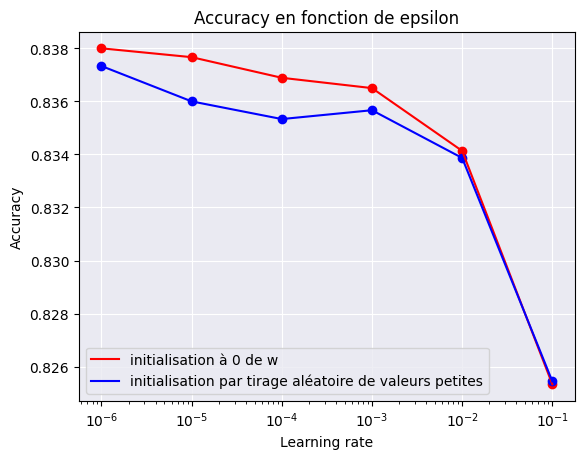

Initialisation à 0 de w
Le learning rate ayant la meilleure accuracy est : 1e-06
Accuracy :  0.8380000000000001
Init perceptron: w=  [0. 0.]


In [ ]:
best_epsilonb_key = key_of_max(dict_accuracy_PB2D)
modeb = best_epsilonb_key <= len(list_epsilon)//2
best_epsilonb = list_epsilon[key_of_max(dict_accuracy_PB2D)%len(list_epsilon)]

#tracé de la variation de l'accuracy en fonction de epsilon
plt.plot(list_epsilon, list(dict_accuracy_PB2D.values())[:len(list_epsilon)], color = "red")
plt.plot(list_epsilon, list(dict_accuracy_PB2D.values())[len(list_epsilon):], color = "blue")
plt.scatter(list_epsilon, list(dict_accuracy_PB2D.values())[:len(list_epsilon)], color = "red")
plt.scatter(list_epsilon, list(dict_accuracy_PB2D.values())[len(list_epsilon):], color = "blue")
plt.legend(["initialisation à 0 de w", "initialisation par tirage aléatoire de valeurs petites"])
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction de epsilon")
plt.grid(color = "white")
plt.xscale("log")
plt.show()

if(modeb):
    print("Initialisation à 0 de w")
else:
    print("Initialisation par tirage aléatoire de valeurs petites")
print("Le learning rate ayant la meilleure accuracy est :", best_epsilonb)
print("Accuracy : ", dict_accuracy_PB2D[best_epsilonb_key])

#rd.seed(42)
PerceptronBiais_2D = ClassifierPerceptronBiais(2, best_epsilonb, modeb) #(dimension, epsilon, init) 
# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []

# Réalisation de N itérations
print("Init perceptron: w= ", PerceptronBiais_2D.w)
N = 100
for i in range(N):
    PerceptronBiais_2D.train_step(train_desc, train_label)
    train_acc.append(PerceptronBiais_2D.accuracy(train_desc, train_label))
    test_acc.append(PerceptronBiais_2D.accuracy(test_desc, test_label))

# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend(['train_acc','test_acc'])
plt.show()


# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
plot_frontiere(X2D, Y2D, PerceptronBiais_2D, step=150)
plot2DSet(X2D, Y2D)

# -----
#les_differences = PerceptronBiais_2D.train(X2D, Y2D)
allw = np.array(PerceptronBiais_2D.get_allw()) 

# Tracé de l'évolution des w:
plt.figure()
plt.plot(allw[:,0]) # première coordonnée du vecteur poids: w1
plt.plot(allw[:,1]) # deuxième coordonnée du vecteur poids: w2
plt.title('Evolution des w au cours des itérations du perceptron')
plt.xlabel('iterations')
plt.legend(['w1','w2'])

# on considère les poids de perceptron2D_biais généré précédente:
allw = np.array(PerceptronBiais_2D.get_allw()) 
cout = [np.sum(1-(np.multiply(np.dot(X2D,w),Y2D))) for w in allw]

plt.figure()
plt.plot(cout)
plt.title('Evolution du coût')

Maintenant que nous avons déterminé le meilleur hyperparamètre, on recrée un Classifieur avec le bon hyperparamètre, et on regarde quel est son taux de bonne classification.

In [40]:
PerceptronBiais_2D = ClassifierPerceptronBiais(2, best_epsilonb, modeb) #(dimension, learning_rate, init)
PerceptronBiais_2D.train(train_desc, train_label)

print("Taux de bonne classification sur le dataset d'entraînement: ", PerceptronBiais_2D.accuracy(train_desc, train_label))
print("Taux de bonne classification sur le dataset de test: ", PerceptronBiais_2D.accuracy(test_desc, test_label))
print("Taux de bonne classification sur le dataset total", PerceptronBiais_2D.accuracy(X2D, Y2D))

Taux de bonne classification sur le dataset d'entraînement:  0.838
Taux de bonne classification sur le dataset de test:  0.834
Taux de bonne classification sur le dataset total 0.837


## Description du dataset 5D :<br>
Notre dataset 5D est constitué de 6 variables décrivant un point $x$ associé à un label ($-1$ ou $1$):<br>
**x1** : La coordonnée en la première dimension de notre point $x$<br>
**x2** : La coordonnée en la deuxième dimension de notre point $x$<br>
**x3** : La coordonnée en la troisième dimension de notre point $x$<br>
**x4** : La coordonnée en la quatrième dimension de notre point $x$<br>
**x5** : La coordonnée en la cinquième dimension de notre point $x$<br>
**label** : Le label associé au point $x$<br><br>
Affichons le dataset :

In [20]:
data5D.head()

,x1,x2,x3,x4,x5,label
0,-0.472352,-0.035994,0.572799,2.017446,-1.865967,-1
1,1.993913,0.984667,-1.180237,1.460067,-0.195743,-1
2,0.923188,1.194008,0.065319,0.909784,0.832256,-1
3,2.540148,-0.427836,-0.113014,3.257095,-1.689755,-1
4,4.331413,0.590868,-1.105335,4.475987,-1.790176,-1


Faisons une brève analyse du dataset :

In [21]:
data5D.describe()

,x1,x2,x3,x4,x5,label
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,-0.068746,0.461769,-0.474193,0.000642,-1.023003,0.00000
std,1.481047,1.193211,1.359913,1.483681,2.019772,1.00025
min,-4.498793,-3.514978,-4.702422,-4.756590,-7.519791,-1.00000
25%,-1.150114,-0.400724,-1.446980,-1.087578,-2.442298,-1.00000
50%,-0.088460,0.461706,-0.495506,-0.029114,-1.048833,0.00000
75%,1.019602,1.264896,0.393675,1.101155,0.360279,1.00000
max,4.841041,6.177008,4.527527,4.475987,5.197440,1.00000


Tout d'abord, nous pouvons constater que notre dataset contient $2000$ entrées.<br>
Les coordonnées (**x1** à **x5**) vont de $-7.519791$ à $6.177008$.<br>
Déterminons le nombre de point ayant pour **label** $-1$ et le nombre de point ayant pour **label** $1$ :

In [22]:
data5D[['label']].value_counts()

label
-1       1000
 1       1000
dtype: int64

On remarque donc qu'il y a $1000$ points qui ont pour **label** $-1$ et $1000$ points qui ont pour **label** $1$.<br><br>
Montrons à présent la distribution de chaque variable selon son label :

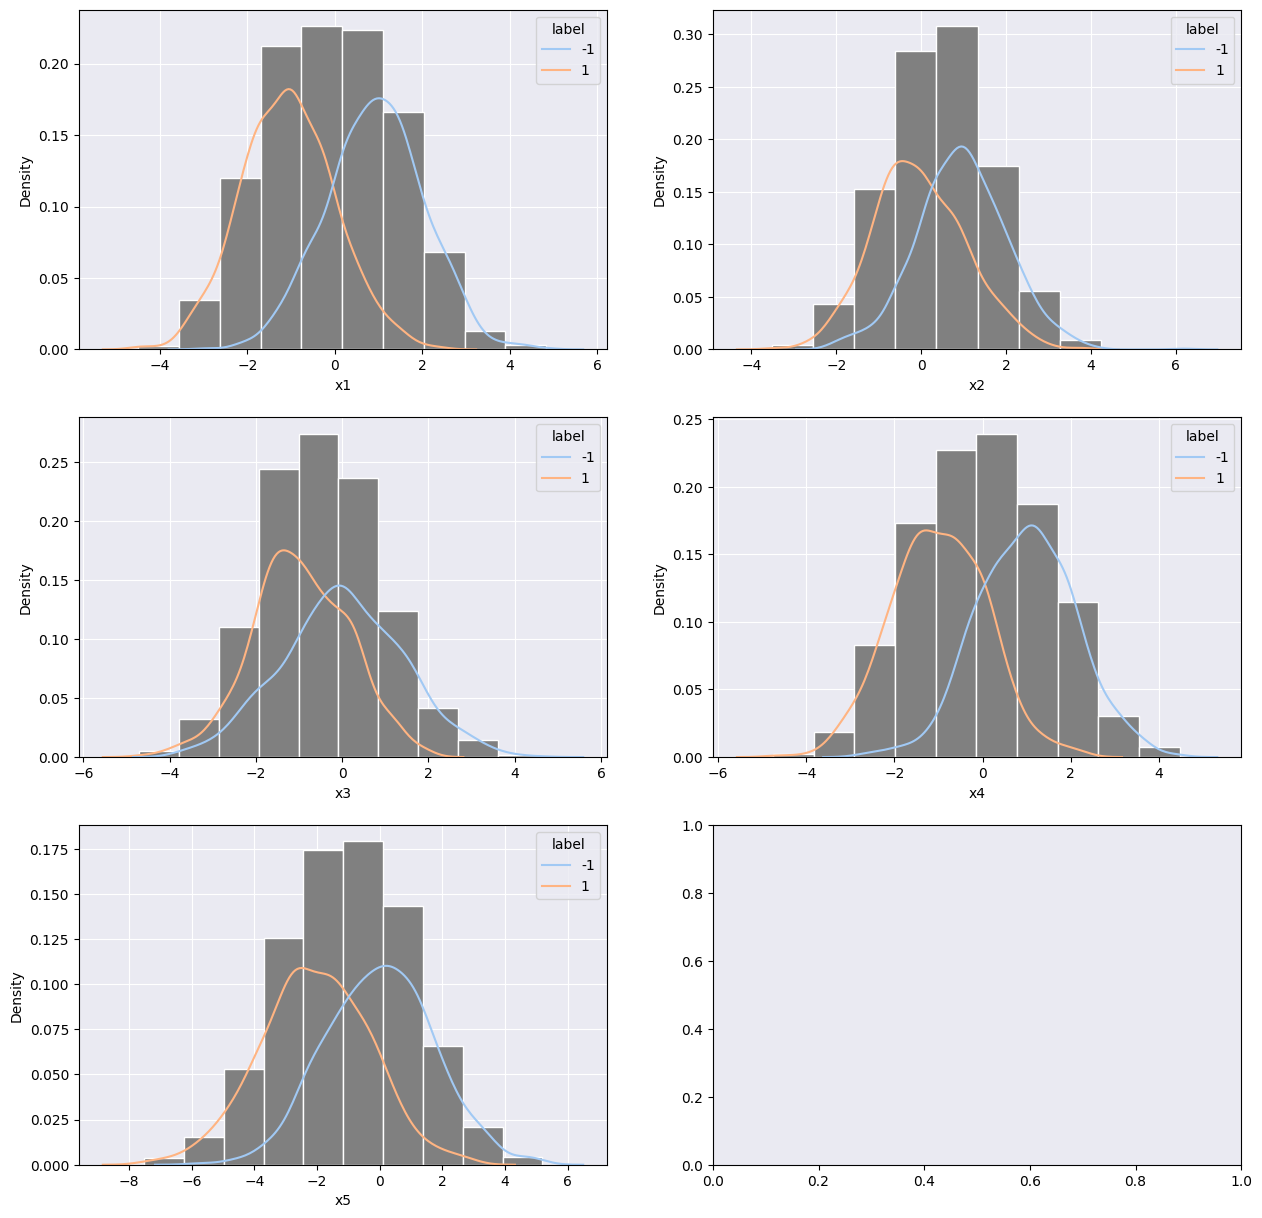

In [23]:
#Avoir un fond gris pour tous les plots
plt.rc('axes', axisbelow=True)
plt.rcParams['axes.facecolor'] = '#EAEAF2'

# Créer un graph pour chaque variable
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Itérer sur toutes les variables sauf Class
for i, var in enumerate(data5D.columns[:-1]):
    # Sélectionner le graph en utilisant l'index de la boucle
    plt.subplot(3,2,i+1)
    plt.grid(color = 'white')
    #Histogramme de la densité de chaque variable
    plt.hist(data5D[var], density=True, color = 'gray', ec="white")
    #Courbe de densité de chaque variable par rapport à la classe
    sns.kdeplot(data=data5D, x=var, hue="label", palette=sns.color_palette("pastel")[:2])
plt.show()

Affichons à présent la répartition des points en fonction des variables pour avoir un aperçu de leurs corrélations.

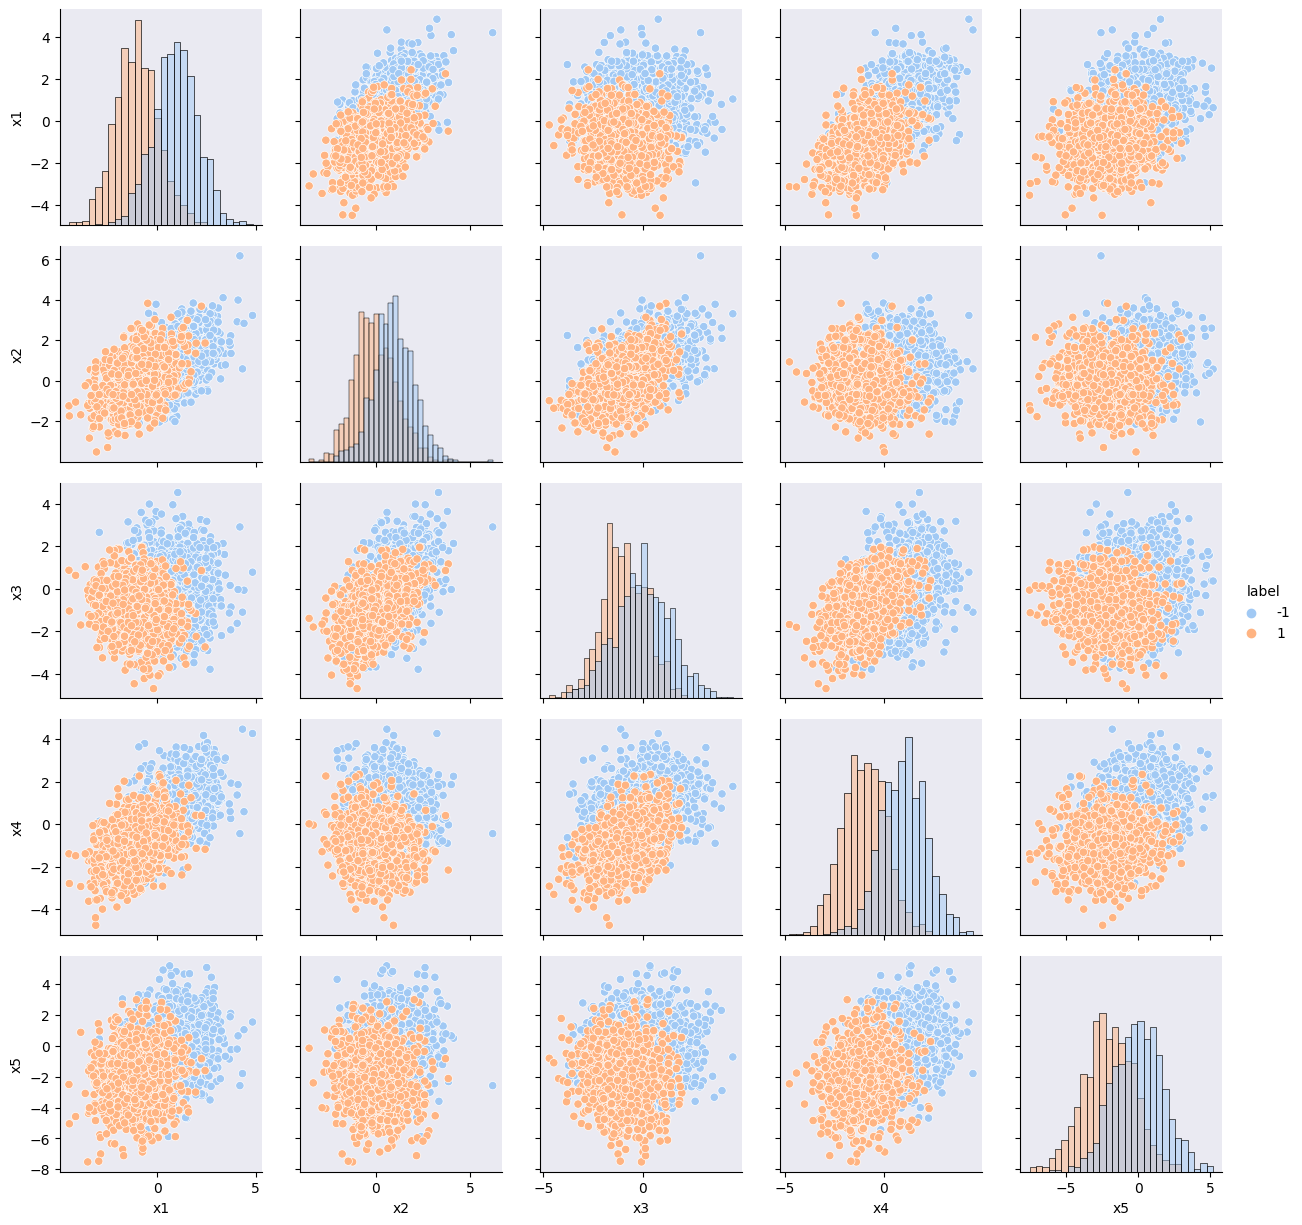

In [24]:
ggpair = sns.PairGrid(data5D, hue="label", palette=sns.color_palette("pastel")[:2])

ggpair.map_diag(sns.histplot)
ggpair.map_offdiag(sns.scatterplot)
ggpair.add_legend()
plt.show()

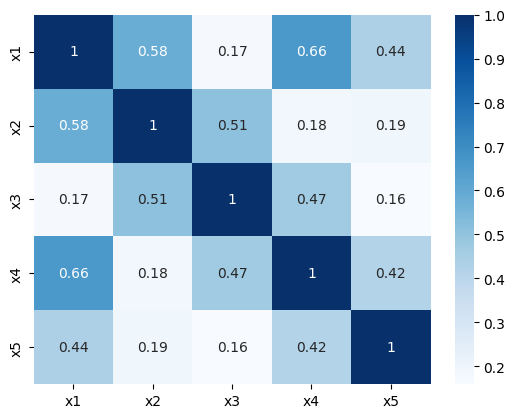

In [25]:
corr = data5D.drop(['label'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()

On remarque qu'aucune variable n'est fortement corrélée avec une autre, ce qui nous assure que l'on va bien pouvoir classifier les points à l'aide de leurs coordonnées.

## Classification du dataset 5D :<br>

Comme précédemment, commençons par séparer nos données en un ensemble d'entraînement et un ensemble de test.<br>

On choisit encore d'affecter $1500$ entrées dans la base d'entraînement et $500$ entrées dans la base de test.

In [26]:
(train_desc, train_label), (test_desc, test_label) = genere_train_test(X5D, Y5D, 750, 750)

print("Base d'apprentissage: ",train_desc.shape, " et ", len(train_label)," labels")
print("Base de test: ",test_desc.shape, " et ", len(test_label)," labels")

Base d'apprentissage:  (1500, 5)  et  1500  labels
Base de test:  (500, 5)  et  500  labels


In [27]:
print(train_desc)

[[-3.0905208  -0.69622254  0.43472461 -0.95957367 -1.08680957]
 [-2.1915761  -0.43446426 -1.13621266 -1.89332449 -1.949561  ]
 [-0.95033727 -1.5778502  -2.87333064 -1.24581774 -1.1672158 ]
 ...
 [ 2.88552495  2.01314713  1.93159885  2.77275214 -1.44717553]
 [ 0.22562234  1.11215882 -1.6622773  -0.91477467  1.59615404]
 [ 0.55342547  1.90017875  1.17931766 -0.16788449  0.73715872]]


### Classifieur KNN (K- Nearest Neighbours) :<br>

Le premier classifieur que nous allons utiliser est le classifieur KNN (k-plus proches voisins) qui n'a qu'un paramètre arbitraire : **k**.<br>
Nous allons donc essayer de déterminer le **k** optimal pour maximiser le taux de bonne classification sur notre dataset.

In [28]:
dict_accuracy_KNN_5D = {}

for k in range(1, 22, 2):
    perfKNN_5D = []
    #Crossvalidation de 10 :
    index = np.random.permutation(len(train_desc)) # mélange des index
    Xm = train_desc[index]
    Ym = train_label[index]
    for i in range(10):
        Xapp, Yapp, Xtest, Ytest = crossval(Xm, Ym, 10, i)
        KNN_5D = ClassifierKNN(5, k) #(dimension, k)
        KNN_5D.train(Xapp, Yapp)
        perfKNN_5D.append(KNN_5D.accuracy(Xtest, Ytest))
        
    #on stocke les résultats dans la liste associée
    dict_accuracy_KNN_5D[k] = analyse_perfs(perfKNN_5D)[0]

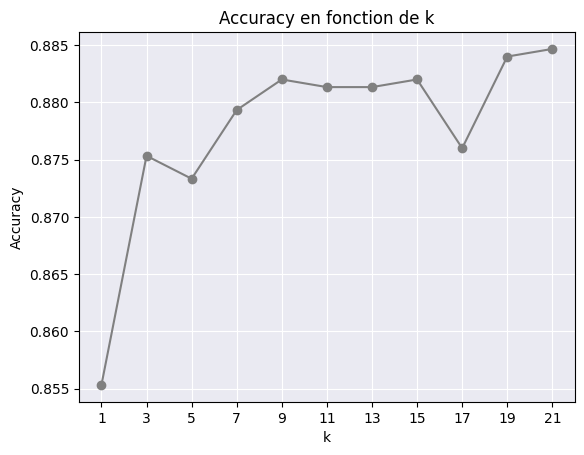

Le k ayant la meilleure accuracy est : 21
Accuracy :  0.8846666666666666
On voit que le k optimal est  21 on choisit donc k =  21 pour notre classifieur final


In [29]:
#tracé de la variation de l'accuracy en fonction de k
plt.plot(list(dict_accuracy_KNN_5D.keys()), list(dict_accuracy_KNN_5D.values()), color = "gray")
plt.scatter(list(dict_accuracy_KNN_5D.keys()), list(dict_accuracy_KNN_5D.values()), color = "gray")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction de k")
plt.grid(color = "white")
plt.xticks(np.arange(1, 22, 2))
plt.show()

best_k_5d = key_of_max(dict_accuracy_KNN_5D)
print("Le k ayant la meilleure accuracy est :", best_k_5d)
print("Accuracy : ", dict_accuracy_KNN_5D[best_k_5d])
print("On voit que le k optimal est ", best_k_5d, "on choisit donc k = ", best_k_5d, "pour notre classifieur final")

Maintenant que nous avons déterminé le meilleur hyperparamètre, on recrée un Classifieur avec le bon hyperparamètre, et on regarde quel est son taux de bonne classification.

In [30]:
KNN_5D = ClassifierKNN(5, best_k_5d) #(dimension, k)
KNN_5D.train(train_desc, train_label)

print("Taux de bonne classification sur le dataset d'entraînement: ", KNN_5D.accuracy(train_desc, train_label))
print("Taux de bonne classification sur le dataset de test: ", KNN_5D.accuracy(test_desc, test_label))
print("Taux de bonne classification sur le dataset total", KNN_5D.accuracy(X5D, Y5D))

Taux de bonne classification sur le dataset d'entraînement:  0.8893333333333333
Taux de bonne classification sur le dataset de test:  0.886
Taux de bonne classification sur le dataset total 0.8885


### Classifieur Perceptron :<br>

Nous allons maintenant utiliser le classifieur Perceptron, qui a 2 paramètres arbitraires:<br>
- **learning_rate** (par défaut 0.01), aussi appelé **epsilon**<br>
- **init** est le mode d'initialisation de w: <br>
    - si True (par défaut): initialisation à 0 de w<br>
    - si False : initialisation par tirage aléatoire de valeurs petites<br>
    
Nous allons donc essayer de déterminer le couple (**epsilon**, **init**) optimal pour maximiser le taux de bonne classification sur notre dataset.

In [31]:
#np.random.seed(42)
dict_accuracy_P5D = {}
list_epsilon = [0.000001,   0.00001,  0.0001,   0.001,   0.01,   0.1,   1]

for init, k1 in zip([True, False], [0, len(list_epsilon)]):
    perfPerceptron_5D = []
    #Crossvalidation de 10 :
    index = np.random.permutation(len(train_desc)) # mélange des index
    Xm = train_desc[index]
    Ym = train_label[index]
    for epsilon, k2 in zip(list_epsilon, range(len(list_epsilon))):
        for i in range(10):
            Xapp, Yapp, Xtest, Ytest = crossval(Xm, Ym, 10, i)
            Perceptron_5D = ClassifierPerceptron(5, epsilon, init) #(dimension, epsilon, init)
            Perceptron_5D.train(Xapp, Yapp)
            perfPerceptron_5D.append(Perceptron_5D.accuracy(Xtest, Ytest))
        
        #on stocke les résultats dans la liste associée
        dict_accuracy_P5D[k1+k2] = analyse_perfs(perfPerceptron_5D)[0]

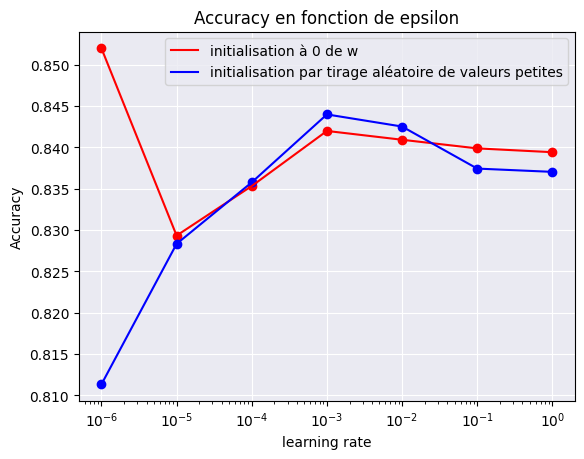

Initialisation à 0 de w
Le learning rate ayant la meilleure accuracy est : 1e-06
Accuracy :  0.8520000000000001
Init perceptron: w=  [0. 0. 0. 0. 0.]


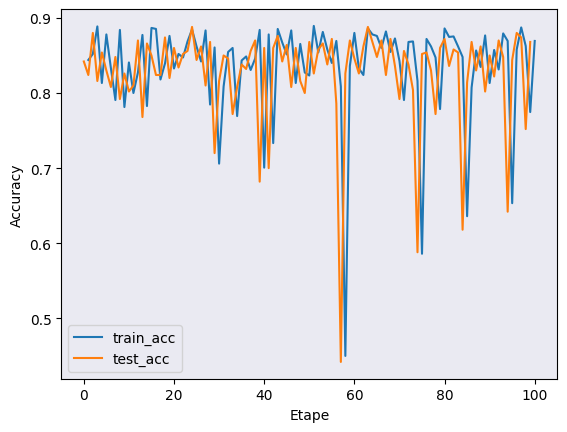

In [32]:
best_epsilon_key = key_of_max(dict_accuracy_P5D)
mode = best_epsilon_key <= len(list_epsilon)//2
best_epsilon = list_epsilon[key_of_max(dict_accuracy_P5D)%len(list_epsilon)]

#tracé de la variation de l'accuracy en fonction de epsilon
plt.plot(list_epsilon, list(dict_accuracy_P5D.values())[:len(list_epsilon)], color = "red")
plt.plot(list_epsilon, list(dict_accuracy_P5D.values())[len(list_epsilon):], color = "blue")
plt.scatter(list_epsilon, list(dict_accuracy_P5D.values())[:len(list_epsilon)], color = "red")
plt.scatter(list_epsilon, list(dict_accuracy_P5D.values())[len(list_epsilon):], color = "blue")
plt.legend(["initialisation à 0 de w", "initialisation par tirage aléatoire de valeurs petites"])
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction de epsilon")
plt.grid(color = "white")
plt.xscale("log")
plt.show()

if(mode):
    print("Initialisation à 0 de w")
else:
    print("Initialisation par tirage aléatoire de valeurs petites")
print("Le learning rate ayant la meilleure accuracy est :", best_epsilon)
print("Accuracy : ", dict_accuracy_P5D[best_epsilon_key])

#rd.seed(42)
Perceptron_5D = ClassifierPerceptron(5, best_epsilon, mode) #(dimension, epsilon, init) 

# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []

# Réalisation de N itérations
print("Init perceptron: w= ", Perceptron_5D.w)
N = 100
for i in range(N):
    Perceptron_5D.train_step(train_desc, train_label)
    train_acc.append(Perceptron_5D.accuracy(train_desc, train_label))
    test_acc.append(Perceptron_5D.accuracy(test_desc, test_label))

# -----
# Apprentissage du perceptron jusqu'à convergence
#les_variations = Perceptron_5D.train(train_desc, train_label)
#print("Nb iterations réalisées: ", len(les_variations))

# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend(['train_acc','test_acc'])
plt.show()

Maintenant que nous avons déterminé le meilleur hyperparamètre, on recrée un Classifieur avec le bon hyperparamètre, et on regarde quel est son taux de bonne classification.

In [33]:
Perceptron_5D = ClassifierPerceptron(5, best_epsilon, mode) #(dimension, learning_rate, init)
Perceptron_5D.train(train_desc, train_label)

print("Taux de bonne classification sur le dataset d'entraînement: ", Perceptron_5D.accuracy(train_desc, train_label))
print("Taux de bonne classification sur le dataset de test: ", Perceptron_5D.accuracy(test_desc, test_label))
print("Taux de bonne classification sur le dataset total", Perceptron_5D.accuracy(X5D, Y5D))

Taux de bonne classification sur le dataset d'entraînement:  0.88
Taux de bonne classification sur le dataset de test:  0.864
Taux de bonne classification sur le dataset total 0.876


### Classifieur Perceptron Biais :<br>

Nous allons terminer par le dernier classifieur, le classifieur Perceptron Biais, qui possède les 2 mêmes paramètres arbitraires que le classifieur Perceptron vu précédemment:<br>
- **learning_rate** (par défaut 0.01), aussi appelé **epsilon**<br>
- **init** est le mode d'initialisation de w: <br>
    - si True (par défaut): initialisation à 0 de w<br>
    - si False : initialisation par tirage aléatoire de valeurs petites<br>
    
Nous allons donc essayer de déterminer le couple (**epsilon**, **init**) optimal pour maximiser le taux de bonne classification sur notre dataset.

In [34]:
#np.random.seed(42) 
dict_accuracy_PB5D = {}
list_epsilon = [0.000001, 0.00001,  0.0001,   0.001,   0.01,   0.1]
for init, k1 in zip([True, False], [0, len(list_epsilon)]):
    perfPerceptronBiais_5D = []
    #Crossvalidation de 10 :
    index = np.random.permutation(len(train_desc)) # mélange des index
    Xm = train_desc[index]
    Ym = train_label[index]
    for epsilon, k2 in zip(list_epsilon, range(len(list_epsilon))):
        for i in range(10):
            Xapp, Yapp, Xtest, Ytest = crossval(Xm, Ym, 10, i)
            PerceptronBiais_5D = ClassifierPerceptronBiais(5, epsilon, init) #(dimension, epsilon, init)
            PerceptronBiais_5D.train(Xapp, Yapp)
            perfPerceptronBiais_5D.append(PerceptronBiais_5D.accuracy(Xtest, Ytest))
        
        #on stocke les résultats dans la liste associée
        dict_accuracy_PB5D[k1+k2] = analyse_perfs(perfPerceptronBiais_5D)[0]

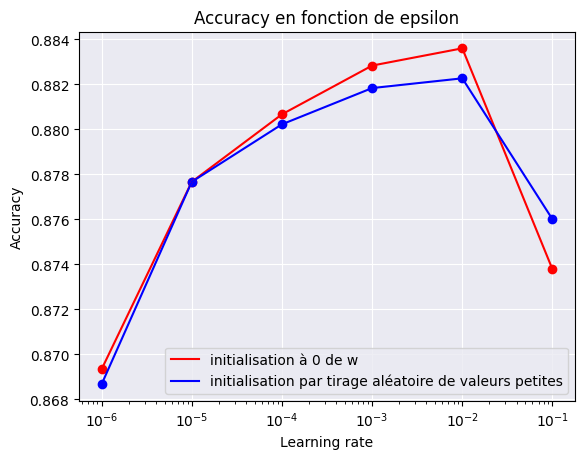

Initialisation par tirage aléatoire de valeurs petites
Le learning rate ayant la meilleure accuracy est : 0.01
Accuracy :  0.8835999999999999
Init perceptron: w=  [-5.16716929e-04  5.27875057e-04 -8.11130581e-04  2.10674552e-05
  6.70169433e-04]


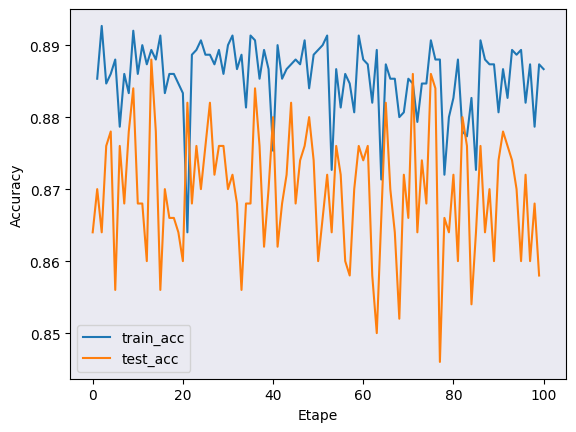

Text(0.5, 1.0, 'Evolution du coût')

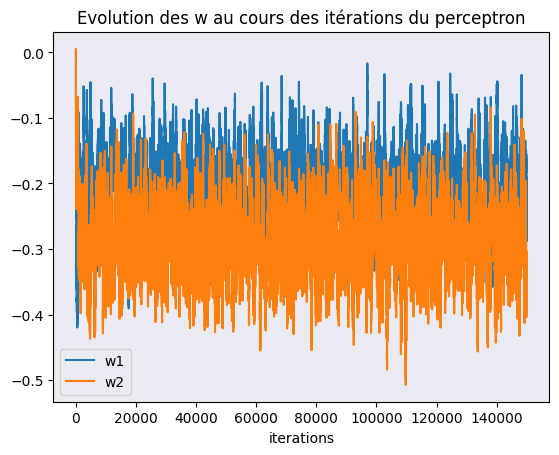

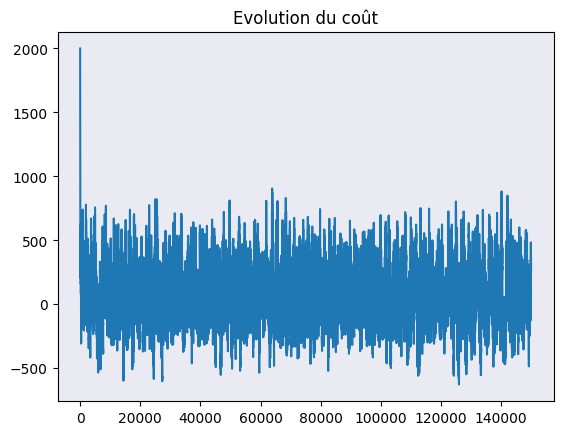

In [35]:
best_epsilonb_key = key_of_max(dict_accuracy_PB5D)
modeb = best_epsilonb_key <= len(list_epsilon)//2
best_epsilonb = list_epsilon[key_of_max(dict_accuracy_PB5D)%len(list_epsilon)]

#tracé de la variation de l'accuracy en fonction de epsilon
plt.plot(list_epsilon, list(dict_accuracy_PB5D.values())[:len(list_epsilon)], color = "red")
plt.plot(list_epsilon, list(dict_accuracy_PB5D.values())[len(list_epsilon):], color = "blue")
plt.scatter(list_epsilon, list(dict_accuracy_PB5D.values())[:len(list_epsilon)], color = "red")
plt.scatter(list_epsilon, list(dict_accuracy_PB5D.values())[len(list_epsilon):], color = "blue")
plt.legend(["initialisation à 0 de w", "initialisation par tirage aléatoire de valeurs petites"])
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction de epsilon")
plt.grid(color = "white")
plt.xscale("log")
plt.show()

if(modeb):
    print("Initialisation à 0 de w")
else:
    print("Initialisation par tirage aléatoire de valeurs petites")
print("Le learning rate ayant la meilleure accuracy est :", best_epsilonb)
print("Accuracy : ", dict_accuracy_PB5D[best_epsilonb_key])

#rd.seed(42)
PerceptronBiais_5D = ClassifierPerceptronBiais(5, best_epsilonb, modeb) #(dimension, epsilon, init) 
# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []

# Réalisation de N itérations
print("Init perceptron: w= ", PerceptronBiais_5D.w)
N = 100
for i in range(N):
    PerceptronBiais_5D.train_step(train_desc, train_label)
    train_acc.append(PerceptronBiais_5D.accuracy(train_desc, train_label))
    test_acc.append(PerceptronBiais_5D.accuracy(test_desc, test_label))

# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend(['train_acc','test_acc'])
plt.show()

"""
# -----
# Apprentissage du perceptron jusqu'à convergence
les_variations = PerceptronBiais_2D.train(train_desc, train_label)
print("Nb iterations réalisées: ", len(les_variations))

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()
"""

# -----
#les_differences = PerceptronBiais_5D.train(X5D, Y5D)
allw = np.array(PerceptronBiais_5D.get_allw()) 

# Tracé de l'évolution des w:
plt.figure()
plt.plot(allw[:,0]) # première coordonnée du vecteur poids: w1
plt.plot(allw[:,1]) # deuxième coordonnée du vecteur poids: w2
plt.title('Evolution des w au cours des itérations du perceptron')
plt.xlabel('iterations')
plt.legend(['w1','w2'])

# on considère les poids de perceptron2D_biais généré précédente:
allw = np.array(PerceptronBiais_5D.get_allw()) 
cout = [np.sum(1-(np.multiply(np.dot(X5D,w),Y5D))) for w in allw]

plt.figure()
plt.plot(cout)
plt.title('Evolution du coût')

Maintenant que nous avons déterminé le meilleur hyperparamètre, on recrée un Classifieur avec le bon hyperparamètre, et on regarde quel est son taux de bonne classification.

In [36]:
PerceptronBiais_5D = ClassifierPerceptronBiais(5, best_epsilonb, modeb) #(dimension, learning_rate, init)
PerceptronBiais_5D.train(train_desc, train_label)

print("Taux de bonne classification sur le dataset d'entraînement: ", PerceptronBiais_5D.accuracy(train_desc, train_label))
print("Taux de bonne classification sur le dataset de test: ", PerceptronBiais_5D.accuracy(test_desc, test_label))
print("Taux de bonne classification sur le dataset total", PerceptronBiais_5D.accuracy(X5D, Y5D))

Taux de bonne classification sur le dataset d'entraînement:  0.888
Taux de bonne classification sur le dataset de test:  0.872
Taux de bonne classification sur le dataset total 0.884


## Conclusion :

Nous pouvons voir que pour les 2 datasets étudiés (le dataset 2D et le dataset 5D), le classifieur ayant obtenu les meilleurs résultats pour le dataset de test est le Classifieur KNN (k-nearest-neigbours), suivi en général du Classifieur Perceptron Biais, pour terminer avec le Classifieur Perceptron.<br>

Si nous devions choisir un Classifieur sur un très très très grand dataset, nous privilègerons le Classifieur Perceptron Biais car il sera bien plus rapide d'avoir une Classification qu'avec le Classifieur KNN.<br>

Cependant, le Classifieur KNN n'ayant pas d'entraînement sur des données d'entraînement comme ses deux congénères, il est le moins soumis au surapprentissage, et est donc très robuste à ce problème là.<br>

Ainsi, en conclusion finale,<br>
- si le dataset à étudier n'est pas extrêmement grand, on privilégera le Classifieur KNN.<br>
- sinon, on privilégera le Classifieur Perceptron Biais.<br>